## import packages

In [2]:
# import packages
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import seaborn as sns
import cv2

## Download dataset and Visualize

In [3]:
import torch.utils
import torch.utils.data


transform = transforms.ToTensor()

Train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
Test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:04<00:00, 40.9MB/s]


In [4]:
# Split Traindata and Validdata
from sklearn.model_selection import StratifiedShuffleSplit
train_labels = np.array(Train_dataset.targets)
test_labels = np.array(Test_dataset.targets)
# same proportion split dataset
# set split function
# if we need to do k cross validation, we should use StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=12)

# get split indices
indics = np.arange(len(train_labels))
train_indices, valid_indices = next(sss.split(indics, train_labels))

# Reset torch Dataset
train_dataset = torch.utils.data.Subset(Train_dataset, train_indices)
valid_dataset = torch.utils.data.Subset(Train_dataset, valid_indices)

In [5]:
# np.bincount: Count the number of occurrences of different integers
print(np.bincount(train_labels[train_indices]))

[4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]


# Visualize the distribution of the data and the images

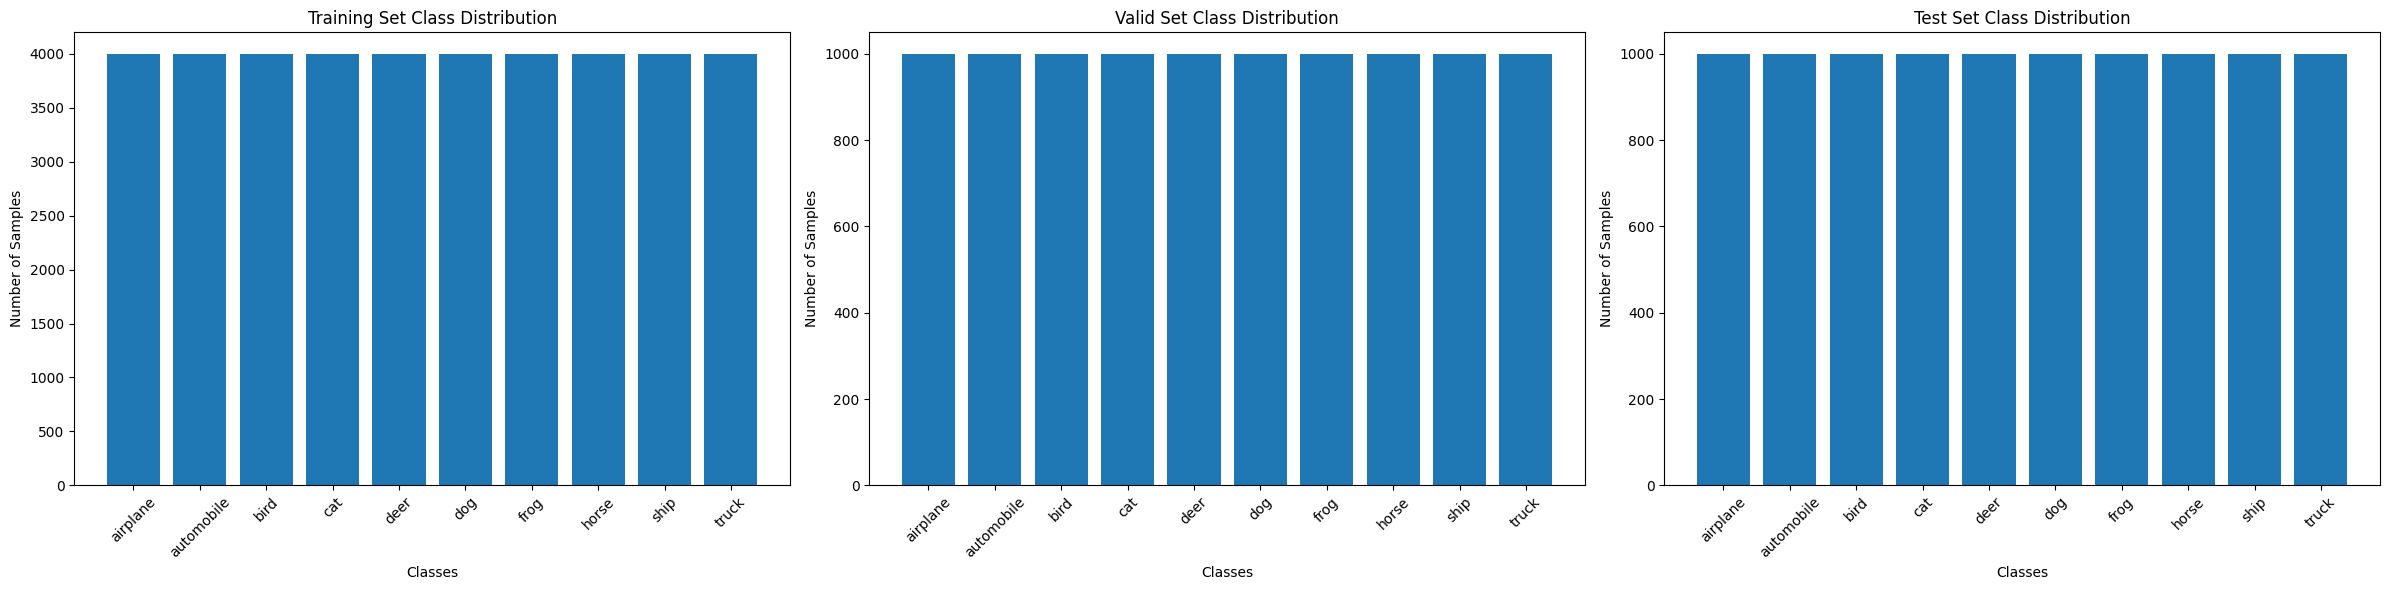

In [6]:
# Visualize the distribution of train dataset
# The CIFAR-10 dataset consists of
# 60000 32x32 colour images
# 10 classes,
# 6000 images per class.

# Visualization
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Train class distribution
axes[0].bar(class_labels, np.bincount(train_labels[train_indices]))
axes[0].set_title('Training Set Class Distribution')
axes[0].set_xlabel('Classes')
axes[0].set_ylabel('Number of Samples')
axes[0].tick_params(axis='x', rotation=45)

# Valid class distribution
axes[1].bar(class_labels, np.bincount(train_labels[valid_indices]))
axes[1].set_title('Valid Set Class Distribution')
axes[1].set_xlabel('Classes')
axes[1].set_ylabel('Number of Samples')
axes[1].tick_params(axis='x', rotation=45)

# Test class distribution
axes[2].bar(class_labels, np.bincount(test_labels))
axes[2].set_title('Test Set Class Distribution')
axes[2].set_xlabel('Classes')
axes[2].set_ylabel('Number of Samples')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

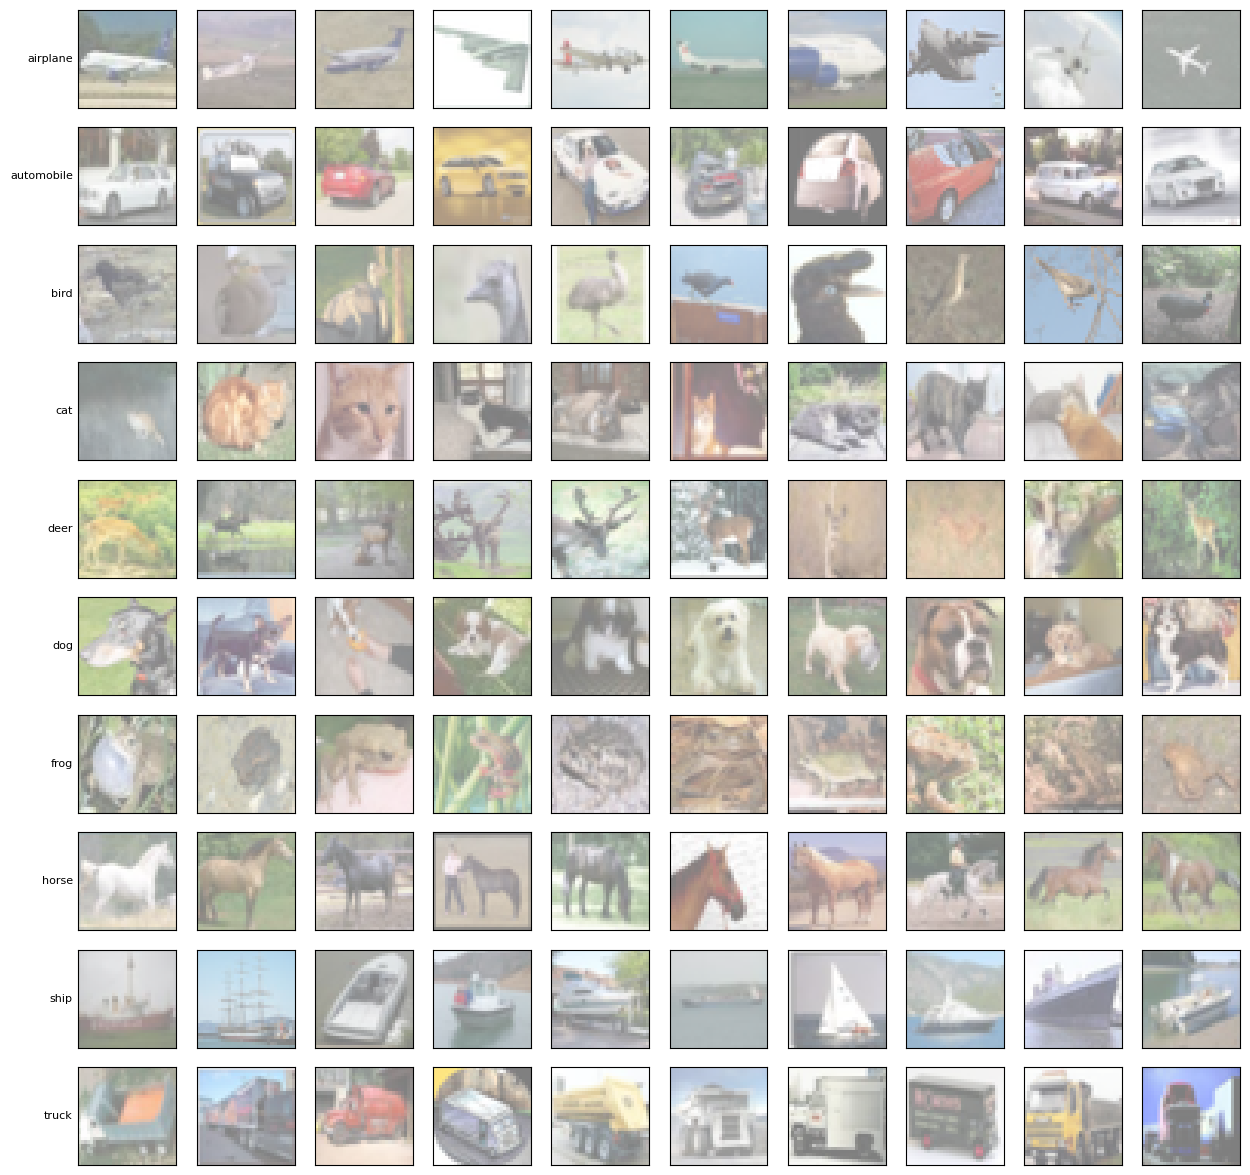

In [7]:
# store images by class
Train_class_images = {i: [] for i in range(10)}
for img, label in train_dataset:
    Train_class_images[label].append(img)

# visualize 10 images per class
num_images = 10
fig, axes = plt.subplots(10, num_images, figsize=(15, 15))

# Set y axis labels
y_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i in range(10):
    for j in range(num_images):
        # Restore image
        img = np.transpose((Train_class_images[i][j]*0.5 + 0.5).numpy(), (1, 2, 0))
        axes[i, j].imshow(img)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
    axes[i, 0].set_ylabel(y_labels[i], rotation=0, ha='right', va='center', fontsize=8)

plt.show()


### Process data

In [8]:
import torchvision.transforms as transforms
import torchvision
import torch

def preprocessed_data(batch_size, num_works=0, method = 'mlp', split=False):
    # compute Normliazation ratio
    temp_transform = transforms.ToTensor()
    temp_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=temp_transform)
    temp_dataloader = torch.utils.data.DataLoader(temp_train_dataset, batch_size=len(temp_train_dataset), shuffle=False)
    temp_data = next(iter(temp_dataloader))[0]
    # temp_data.shape = [B, C, H, W]
    channel_mean = torch.mean(temp_data, dim=(0, 2, 3))
    channel_std = torch.std(temp_data, dim=(0, 2, 3))

    def flatten(x):
        return torch.flatten(x)
    # Get method for different model
    if method == 'mlp':
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=channel_mean, std=channel_std),
            transforms.Lambda(flatten)
        ])
        test_transform = train_transform
    elif method == "resnet":
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=channel_mean, std=channel_std),
        ])
        test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=channel_mean, std=channel_std),
        ])
    elif method == "vit":
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=channel_mean, std=channel_std),
        ])
        test_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.ToTensor(),
            transforms.Normalize(mean=channel_mean, std=channel_std),
        ])

    # Create dataset
    Train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    Test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

    # Create dataloader
    train_dataloader = torch.utils.data.DataLoader(Train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_works)
    test_dataloader = torch.utils.data.DataLoader(Test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_works)

    return train_dataloader, test_dataloader


In [9]:
# test preprocess data
train, test = preprocessed_data(128,method='vit')
next(iter(train))

[tensor([[[[-1.2431, -0.9891, -0.7192,  ...,  1.2016,  1.6937,  1.7890],
           [-1.2907, -1.0367, -0.7669,  ...,  1.3445,  1.7731,  1.8525],
           [-1.3225, -1.0685, -0.8304,  ...,  1.5508,  1.8048,  1.8525],
           ...,
           [-1.9892, -1.9892, -1.9892,  ..., -1.9892, -1.9892, -1.9892],
           [-1.9892, -1.9892, -1.9892,  ..., -1.9892, -1.9892, -1.9892],
           [-1.9892, -1.9892, -1.9892,  ..., -1.9892, -1.9892, -1.9892]],
 
          [[-0.6918, -0.5307, -0.3052,  ...,  1.3859,  1.8208,  1.8530],
           [-0.6918, -0.5307, -0.3213,  ...,  1.5309,  1.8852,  1.9013],
           [-0.6595, -0.5146, -0.3857,  ...,  1.7080,  1.9013,  1.9013],
           ...,
           [-1.9802, -1.9802, -1.9802,  ..., -1.9802, -1.9802, -1.9802],
           [-1.9802, -1.9802, -1.9802,  ..., -1.9802, -1.9802, -1.9802],
           [-1.9802, -1.9802, -1.9802,  ..., -1.9802, -1.9802, -1.9802]],
 
          [[-0.1629, -0.0729,  0.1519,  ...,  1.5761,  1.9359,  1.9209],
           [-

In [10]:
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, confusion_matrix, classification_report
def plot_accuracy_and_confusion_matrix(y_true, y_pred, class_names, title, Method_name):
    report = classification_report(y_true, y_pred)

    print(f"{Method_name}")
    print(report)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

# Train MLP, Resnet, Vit on CIFAR10

In [11]:
import torch.nn as nn
from torchvision import models

class MLP(nn.Module):
    def __init__(self, input_dim = 3*32*32, hidden_dim = 521, num_classes = 10):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.layers(x)

class Restnet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.model = models.resnet18(pretrained=False)
        # adjust first conv to accommodate Low-resolution images
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        # Remove maxpool to increase information
        self.model.maxpool = nn.Identity()
        # modify output dimension
        self.model.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        return self.model(x)

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=64):
        super().__init__()
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        num_patches = (img_size // patch_size) ** 2
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches, embed_dim))

    def forward(self, x):
        # [B, C, H, W] → [B, embed_dim, 8, 8]
        x = self.proj(x)
        # [B, num_patches, embed_dim]
        x = x.flatten(2).transpose(1, 2)
        x += self.pos_embed
        return x

class ViT(nn.Module):
    def __init__(self, num_classes=10, embed_dim=64, depth=4, num_heads=4):
        super().__init__()
        self.patch_embed = PatchEmbedding(embed_dim=embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=256, dropout=0.1, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # [B, 64, 64]
        x = self.patch_embed(x)
        x = self.transformer(x)
        x = x.mean(dim=1)
        return self.head(x)



def get_model(model_name = "mlp"):
    if model_name == 'mlp':
        return MLP()
    elif model_name == 'resnet':
        return Restnet()
    elif model_name == 'vit':
        return ViT()


In [12]:
import torch.optim as optim
import numpy as np
def train_models_CIFAR10(model_name, epochs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_loader, test_loader = preprocessed_data(128, method=model_name)
    model = get_model(model_name).to(device)
    # return for test
    best_model = None
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),lr=2e-3)
    best_acc = 0.0
    pred = []
    lab = []
    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0,0,0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            # output.shape=[b,num_classes]
            # return maxnum and max index
            _, predictions = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += torch.sum(predictions==labels).item()
        train_acc = 100 * correct / total

        val_acc = evaluate_model_CIFAR10(model, test_loader, criterion, device)

        # save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model = model
            torch.save(model.state_dict(), f'best_{model.__class__.__name__}.pth')

        print(f'Epoch {epoch+1}: '
              f'Train Loss: {train_loss/len(train_loader):.3f},'
              f'Acc: {train_acc:.2f}%,'
              f'Val Acc: {val_acc:.2f}%')
    return best_model, test_loader



def evaluate_model_CIFAR10(model, test_loader, criterion, device):
    model.eval()
    correct, total, loss = 0, 0, 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            _, predictions = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += torch.sum(predictions==labels).item()
    return 100 * correct / total

def final_eval(model, test_loader, title, method_name):
  model.eval()
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  pred = []
  label = []
  with torch.no_grad():
    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      _, predictions = torch.max(outputs, dim=1)
      label.append(np.array(labels.cpu()).flatten())
      pred.append(np.array(predictions.cpu()).flatten())
    label = np.concatenate(label)
    pred = np.concatenate(pred)
    plot_accuracy_and_confusion_matrix(label, pred, class_labels, title, method_name)

Epoch 1: Train Loss: 1.807,Acc: 35.65%,Val Acc: 44.36%
Epoch 2: Train Loss: 1.622,Acc: 42.02%,Val Acc: 47.69%
Epoch 3: Train Loss: 1.549,Acc: 44.71%,Val Acc: 50.10%
Epoch 4: Train Loss: 1.496,Acc: 46.49%,Val Acc: 50.77%
Epoch 5: Train Loss: 1.450,Acc: 48.29%,Val Acc: 51.67%
Epoch 6: Train Loss: 1.417,Acc: 49.42%,Val Acc: 52.38%
Epoch 7: Train Loss: 1.389,Acc: 50.37%,Val Acc: 53.14%
Epoch 8: Train Loss: 1.365,Acc: 51.02%,Val Acc: 53.95%
Epoch 9: Train Loss: 1.343,Acc: 52.04%,Val Acc: 54.07%
Epoch 10: Train Loss: 1.324,Acc: 52.68%,Val Acc: 54.10%
Epoch 11: Train Loss: 1.309,Acc: 53.31%,Val Acc: 55.11%
Epoch 12: Train Loss: 1.286,Acc: 54.15%,Val Acc: 55.35%
Epoch 13: Train Loss: 1.280,Acc: 54.14%,Val Acc: 55.46%
Epoch 14: Train Loss: 1.262,Acc: 54.81%,Val Acc: 55.95%
Epoch 15: Train Loss: 1.246,Acc: 55.51%,Val Acc: 55.51%
Epoch 16: Train Loss: 1.232,Acc: 56.07%,Val Acc: 55.86%
Epoch 17: Train Loss: 1.215,Acc: 56.63%,Val Acc: 56.31%
Epoch 18: Train Loss: 1.207,Acc: 56.94%,Val Acc: 56.20%
E

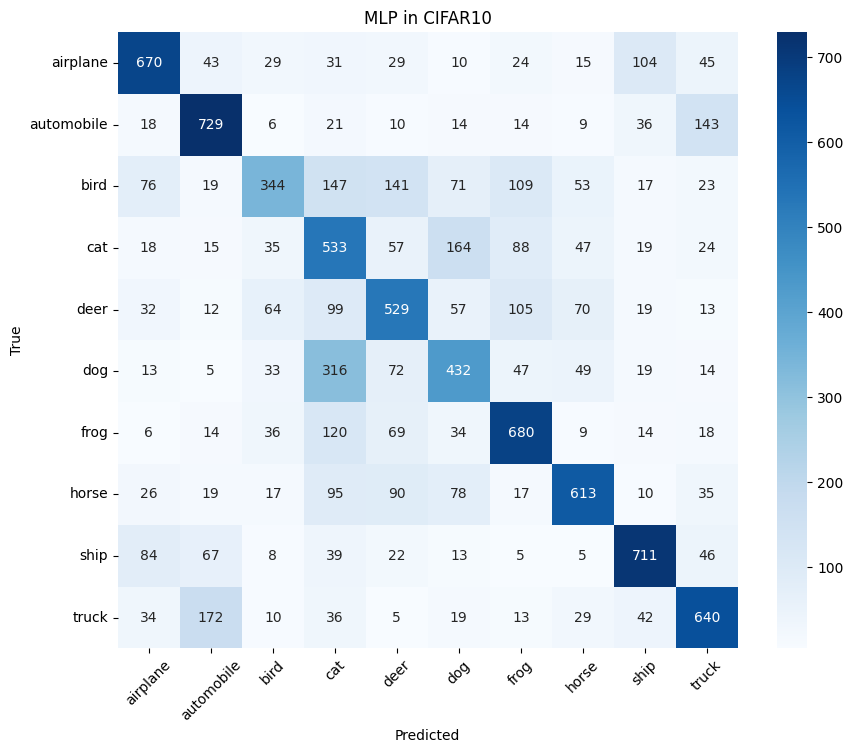

In [ ]:
model_name_list = ['mlp', 'resnet', 'vit']
epochs = 100
model, test_loader = train_models_CIFAR10(model_name_list[0], epochs)
final_eval(model, test_loader, "MLP in CIFAR10",model_name_list[0])

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Loss: 1.527,Acc: 43.97%,Val Acc: 55.76%
Epoch 2: Train Loss: 1.030,Acc: 63.10%,Val Acc: 57.98%
Epoch 3: Train Loss: 0.814,Acc: 70.96%,Val Acc: 74.90%
Epoch 4: Train Loss: 0.659,Acc: 76.92%,Val Acc: 73.51%
Epoch 5: Train Loss: 0.557,Acc: 80.69%,Val Acc: 80.78%
Epoch 6: Train Loss: 0.486,Acc: 83.33%,Val Acc: 81.43%
Epoch 7: Train Loss: 0.433,Acc: 85.05%,Val Acc: 82.85%
Epoch 8: Train Loss: 0.390,Acc: 86.49%,Val Acc: 85.20%
Epoch 9: Train Loss: 0.356,Acc: 87.83%,Val Acc: 86.58%
Epoch 10: Train Loss: 0.321,Acc: 88.88%,Val Acc: 81.92%
Epoch 11: Train Loss: 0.294,Acc: 89.79%,Val Acc: 86.14%
Epoch 12: Train Loss: 0.272,Acc: 90.57%,Val Acc: 87.82%
Epoch 13: Train Loss: 0.249,Acc: 91.27%,Val Acc: 87.48%
Epoch 14: Train Loss: 0.229,Acc: 92.07%,Val Acc: 88.28%
Epoch 15: Train Loss: 0.217,Acc: 92.31%,Val Acc: 89.09%
Epoch 16: Train Loss: 0.197,Acc: 93.10%,Val Acc: 88.59%
Epoch 17: Train Loss: 0.182,Acc: 93.63%,Val Acc: 89.42%
Epoch 18: Train Loss: 0.167,Acc: 94.12%,Val Acc: 89.30%
E

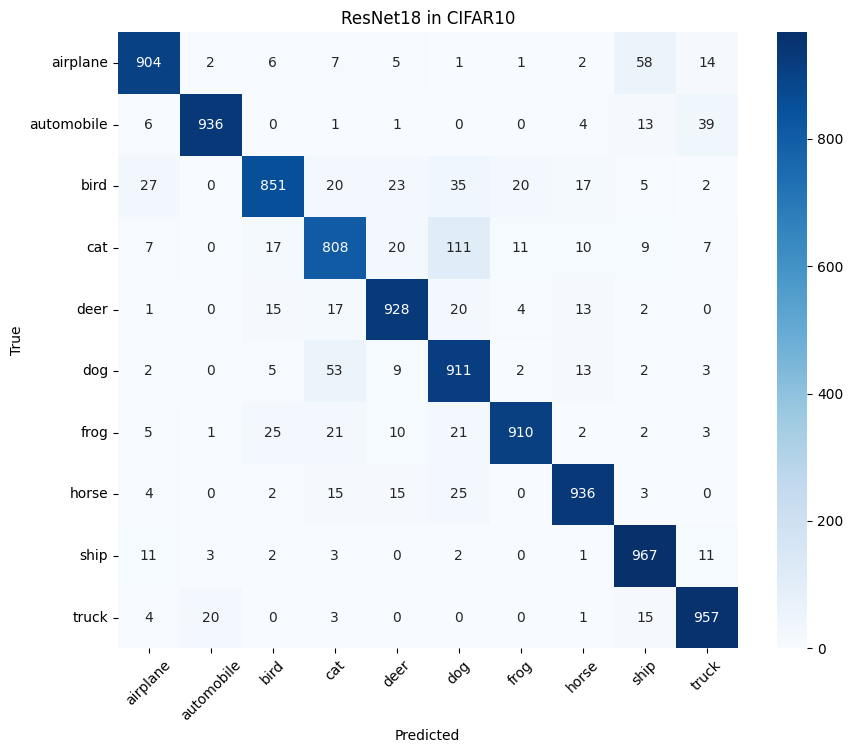

In [ ]:
model_name_list = ['mlp', 'resnet', 'vit']
epochs = 50
model, test_loader = train_models_CIFAR10(model_name_list[1], epochs)
final_eval(model, test_loader, "ResNet18 in CIFAR10", model_name_list[1])

Epoch 1: Train Loss: 1.831,Acc: 31.27%,Val Acc: 42.04%
Epoch 2: Train Loss: 1.560,Acc: 42.74%,Val Acc: 44.98%
Epoch 3: Train Loss: 1.435,Acc: 47.79%,Val Acc: 50.25%
Epoch 4: Train Loss: 1.357,Acc: 50.30%,Val Acc: 53.47%
Epoch 5: Train Loss: 1.296,Acc: 52.94%,Val Acc: 54.60%
Epoch 6: Train Loss: 1.230,Acc: 55.54%,Val Acc: 56.48%
Epoch 7: Train Loss: 1.186,Acc: 57.10%,Val Acc: 57.80%
Epoch 8: Train Loss: 1.141,Acc: 59.13%,Val Acc: 60.40%
Epoch 9: Train Loss: 1.103,Acc: 60.27%,Val Acc: 61.10%
Epoch 10: Train Loss: 1.077,Acc: 61.26%,Val Acc: 61.71%
Epoch 11: Train Loss: 1.046,Acc: 62.26%,Val Acc: 64.41%
Epoch 12: Train Loss: 1.026,Acc: 63.13%,Val Acc: 63.68%
Epoch 13: Train Loss: 1.004,Acc: 64.15%,Val Acc: 62.65%
Epoch 14: Train Loss: 0.983,Acc: 64.97%,Val Acc: 65.58%
Epoch 15: Train Loss: 0.969,Acc: 65.36%,Val Acc: 66.26%
Epoch 16: Train Loss: 0.952,Acc: 66.05%,Val Acc: 66.66%
Epoch 17: Train Loss: 0.941,Acc: 66.51%,Val Acc: 66.23%
Epoch 18: Train Loss: 0.922,Acc: 67.24%,Val Acc: 67.26%
E

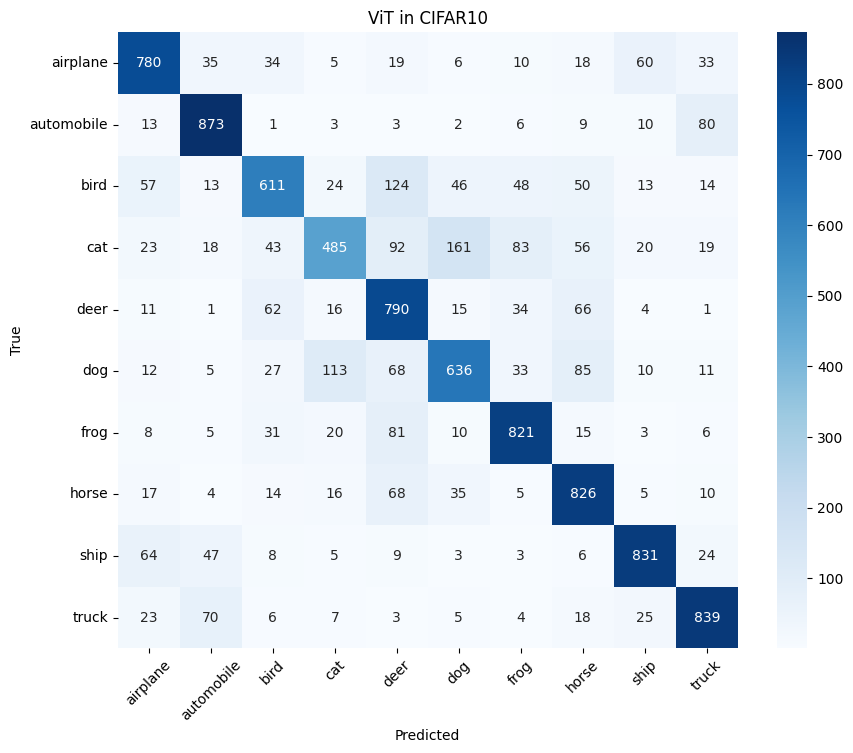

In [13]:
model_name_list = ['mlp', 'resnet', 'vit']
epochs = 70
model, test_loader = train_models_CIFAR10(model_name_list[2], epochs)
final_eval(model, test_loader, "ViT in CIFAR10", model_name_list[2])